In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
import numpy as np
import matplotlib.pyplot as plt
from qutip import Qobj, sigmax, sigmaz, tensor, destroy, qeye, basis, fidelity
from scipy.optimize import minimize
from matplotlib.ticker import MaxNLocator
import qutip as qp

In [2]:
# Define parameters
omega_0 = 1  # cavity frequency (ω_0)
Omega = 1  # qubit frequency (Ω)
lambda_val = 0.8 # coupling strength (λ)
tru = 50  # Hilbert space dimension for cavity mode
tau = 0.02  # Fixed time step for evolution
steps=100
shots=1

In [3]:
# Cavity mode operator
a = tensor(destroy(tru), qeye(2))

# atom operators
sz = tensor(qeye(tru), sigmaz()) 
sx = tensor(qeye(tru), sigmax())  

# The Rabi model Hamiltonian
H1 = omega_0 * a.dag() * a  
H2 = (Omega / 2) * sz  
H3 = lambda_val * (a.dag() + a) * sx  
H = H1 + H2 + H3  

In [4]:
op=H

fidelities_origin = []
eigenvalues_1, _ = np.linalg.eig(H1)
eigenvalues_2, _ = np.linalg.eig(H2)
eigenvalues_3, _ = np.linalg.eig(H3)

c1 = max(eigenvalues_1)
c2 = max(eigenvalues_2)
c3 = max(eigenvalues_3)

k = c1 + c2 + c3
    
# Probabilities for random selection
p1 = c1 / k
p2 = c2 / k
p3 = c3 / k
ps=[p1,p2,p3]

# Normalized Hamiltonians
H1_norm = H1 / c1
H2_norm = H2 / c2
H3_norm = H3 / c3
Hs=[H1_norm,H2_norm,H3_norm]
    
    
#initial_state=tensor(basis(tru,5), basis(2, 0))
initial_state=(tensor(basis(tru,5), basis(2, 0))+tensor(basis(tru,2), basis(2, 0)))/np.sqrt(2)
rho = initial_state*initial_state.dag() 
exact_state=initial_state

for j in range(steps):

    exact_state = (-1j * H * tau).expm()*exact_state # evolution of exact statae
    rho_exact = exact_state*exact_state.dag()
    
    # evolution of random state in channel formula 
    rhos=[]
    for i in range(3):
        rhos.append(ps[i]*(-1j * Hs[i] * tau*k).expm() * rho * (1j * Hs[i] * tau*k).expm())
    rho=sum(rhos)
    
    # Calculate fidelity
    fidelity_origin = fidelity(rho,rho_exact)
    fidelities_origin.append(fidelity_origin)

In [5]:
op=H

fidelities_ew = []
c1 = 0.1
c2 = 0.1
c3 = 0.1

k = c1 + c2 + c3
    
# Probabilities for random selection
p1 = c1 / k
p2 = c2 / k
p3 = c3 / k
ps=[p1,p2,p3]

# Normalized Hamiltonians
H1_norm = H1 / c1
H2_norm = H2 / c2
H3_norm = H3 / c3
Hs=[H1_norm,H2_norm,H3_norm]
    
    
#initial_state=tensor(basis(tru,5), basis(2, 0))
initial_state=(tensor(basis(tru,5), basis(2, 0))+tensor(basis(tru,2), basis(2, 0)))/np.sqrt(2)
rho = initial_state*initial_state.dag() 
exact_state=initial_state

for j in range(steps):

    exact_state = (-1j * H * tau).expm()*exact_state # evolution of exact statae
    rho_exact = exact_state*exact_state.dag()
    
    # evolution of random state in channel formula 
    rhos=[]
    for i in range(3):
        rhos.append(ps[i]*(-1j * Hs[i] * tau*k).expm() * rho * (1j * Hs[i] * tau*k).expm())
    rho=sum(rhos)
    
    # Calculate fidelity
    fidelity_ew = fidelity(rho,rho_exact)
    fidelities_ew.append(fidelity_ew)

In [6]:
terms=[]
terms.append(H1)
terms.append(H2)
terms.append(H3)

In [7]:
def D_ij(H_i, H_j, rho):
    a = 1j * (H_j * rho - rho * H_j)
    b = 1j * (H_i * a - a * H_i)
    return b

In [8]:
dt = 0.001

In [9]:
def D(H, rho, error_list):
    T1 = qp.expect(H,rho) + error_list[0]
    T2 = qp.expect(H * H,rho) + error_list[1]
    T3 = qp.expect(H * H * H,rho) + error_list[2]
    T4 = qp.expect(H * H * H * H,rho) + error_list[3]
    result = np.sqrt(abs(6*T2**2 - 8*T1*T3 + 2*T4))
    return result

In [10]:
p1_list=[]
p2_list=[]
p3_list=[]

In [11]:
def Fidelity(steps, tau, shots):
    
    Fidelity_list = []
    
    initial_state=(tensor(basis(tru,5), basis(2, 0))+tensor(basis(tru,2), basis(2, 0)))/np.sqrt(2)
    rho_initial = initial_state*initial_state.dag() 
    exact_state=initial_state
    
    rho_steps_list = steps * [0]
    for i in range(shots):
        print(i)
        rho = rho_initial
        for j in range(steps):
            a = [0] * 4
            b = [0] * 4
            c = [0] * 4
            for k in range(4):
                a[k] = np.random.normal(loc=0, scale=0)
                b[k] = np.random.normal(loc=0, scale=0)
                c[k] = np.random.normal(loc=0, scale=0)
            
            D11 = D(terms[0], rho, a)
            D22 = D(terms[1], rho, b)
            D33 = D(terms[2], rho, c)
            
            Dsum=np.sqrt(D11)+np.sqrt(D22)+np.sqrt(D33)
            p1=np.sqrt(D11)/Dsum
            p2=np.sqrt(D22)/Dsum
            p3=np.sqrt(D33)/Dsum
            ps = [p1,p2,p3]
            
            p1_list.append(p1)
            p2_list.append(p2)
            p3_list.append(p3)
            
            rand= np.random.rand()
            if rand < ps[0]:
                rho = (-1j * H1 * tau/p1).expm() * rho * (1j * H1 * tau/p1).expm()
            elif rand < ps[0] + ps[1]:
                rho = (-1j * H2 * tau/p2).expm() * rho * (1j * H2 * tau/p2).expm()
            else:
                rho = (-1j * H3 * tau/p3).expm() * rho * (1j * H3 * tau/p3).expm()
            rho_steps_list[j] += rho / shots

    for i in range(steps):
        
        rho_exact = exact_state*exact_state.dag()
        
        Fidelity = fidelity(rho_steps_list[i],rho_exact)
        Fidelity_list.append(Fidelity)
        
        exact_state = (-1j * H * tau).expm()*exact_state
    
    return Fidelity_list

In [12]:
Fidelity_list = Fidelity(steps, tau, shots)

0


In [13]:
print(Fidelity_list)

[0.9970212949352103, 0.9984772296452724, 0.9979739860336988, 0.997436046505498, 0.9920594969061478, 0.9956494030524772, 0.9970682993922474, 0.9929042922342523, 0.9952564187148286, 0.9951435192479055, 0.9924095764326786, 0.9931294225289276, 0.9911025051347784, 0.9899941602387526, 0.9833770549595406, 0.97117239485379, 0.9773446841867066, 0.9806421048775588, 0.9932017365788186, 0.9945177609466622, 0.9872830794194373, 0.9743090309920116, 0.9850793937341487, 0.9926814919952888, 0.9967928697965274, 0.9970884755390379, 0.9932425479482161, 0.9849238394400718, 0.9718256987531328, 0.9536687728625168, 0.9302170963205363, 0.9527535029796534, 0.9280289984516096, 0.9506901129381442, 0.9684801821602064, 0.9809256382111309, 0.9876263535493304, 0.9882580006307146, 0.9825836384016544, 0.9858838288659427, 0.9821699914665024, 0.9831484655191854, 0.9776498328892466, 0.9858860737953974, 0.9911921202691519, 0.9886689995619137, 0.9837431198914843, 0.9696376173547716, 0.9587100289182044, 0.9746192990586282, 0.

In [14]:
print(fidelities_origin)

[0.9950906698692747, 0.990213075686697, 0.9853105629674153, 0.9803350456333777, 0.9752560166329841, 0.9700390337576518, 0.9646686503734653, 0.9591327835277839, 0.9534272170324102, 0.947557479872961, 0.9415314176119727, 0.9353665268837137, 0.9290791218190882, 0.9226873325785103, 0.9162206578745928, 0.9096892240887423, 0.9031211533300956, 0.8965370683619798, 0.8899481921079867, 0.883374439640105, 0.8768280025748018, 0.870317005049339, 0.8638490413208224, 0.85743234582494, 0.8510667335613216, 0.8447554983555422, 0.838502858276189, 0.832297603238859, 0.8261501319588745, 0.8200470602923424, 0.8139914247471027, 0.8079841097712198, 0.802019952332919, 0.7960965467396928, 0.7902128305741142, 0.7843669410825697, 0.7785606541430026, 0.7727899120489186, 0.7670575834114973, 0.7613647940189726, 0.7557076328891635, 0.7500874747036649, 0.744510180942968, 0.7389709519711566, 0.7334704445916869, 0.7280124864516788, 0.7225925477464282, 0.7172123267829299, 0.7118758849262955, 0.7065750499517417, 0.7013123

In [15]:
print(fidelities_ew)

[0.997061862409177, 0.9941410295359722, 0.9912343845215951, 0.9883365385971331, 0.9854473289771967, 0.9825618409964371, 0.97967577312191, 0.976786444572688, 0.9738964240596852, 0.9709989380766613, 0.9680983599089786, 0.9651908904111267, 0.9622749581859695, 0.9593563084724699, 0.956428899092442, 0.9534953812682483, 0.9505536044651409, 0.9476073993496266, 0.9446531192709907, 0.9416859354203653, 0.9387111470988412, 0.9357256876051396, 0.9327241687606023, 0.9297082205957156, 0.926674696356839, 0.9236203391568092, 0.9205460328637556, 0.917446199539607, 0.9143213944786798, 0.9111733899562733, 0.9079965414736115, 0.904790073784724, 0.9015531575016854, 0.8982851930269554, 0.8949902430843198, 0.8916635013206434, 0.8883076494862374, 0.8849202503581554, 0.8815082418538395, 0.8780661236284772, 0.8745979188670859, 0.8711056427651954, 0.8675880453619819, 0.8640462643308396, 0.8604817027552629, 0.8568970488639798, 0.8532912097485581, 0.8496654136757492, 0.8460217318872513, 0.8423561844534846, 0.83867

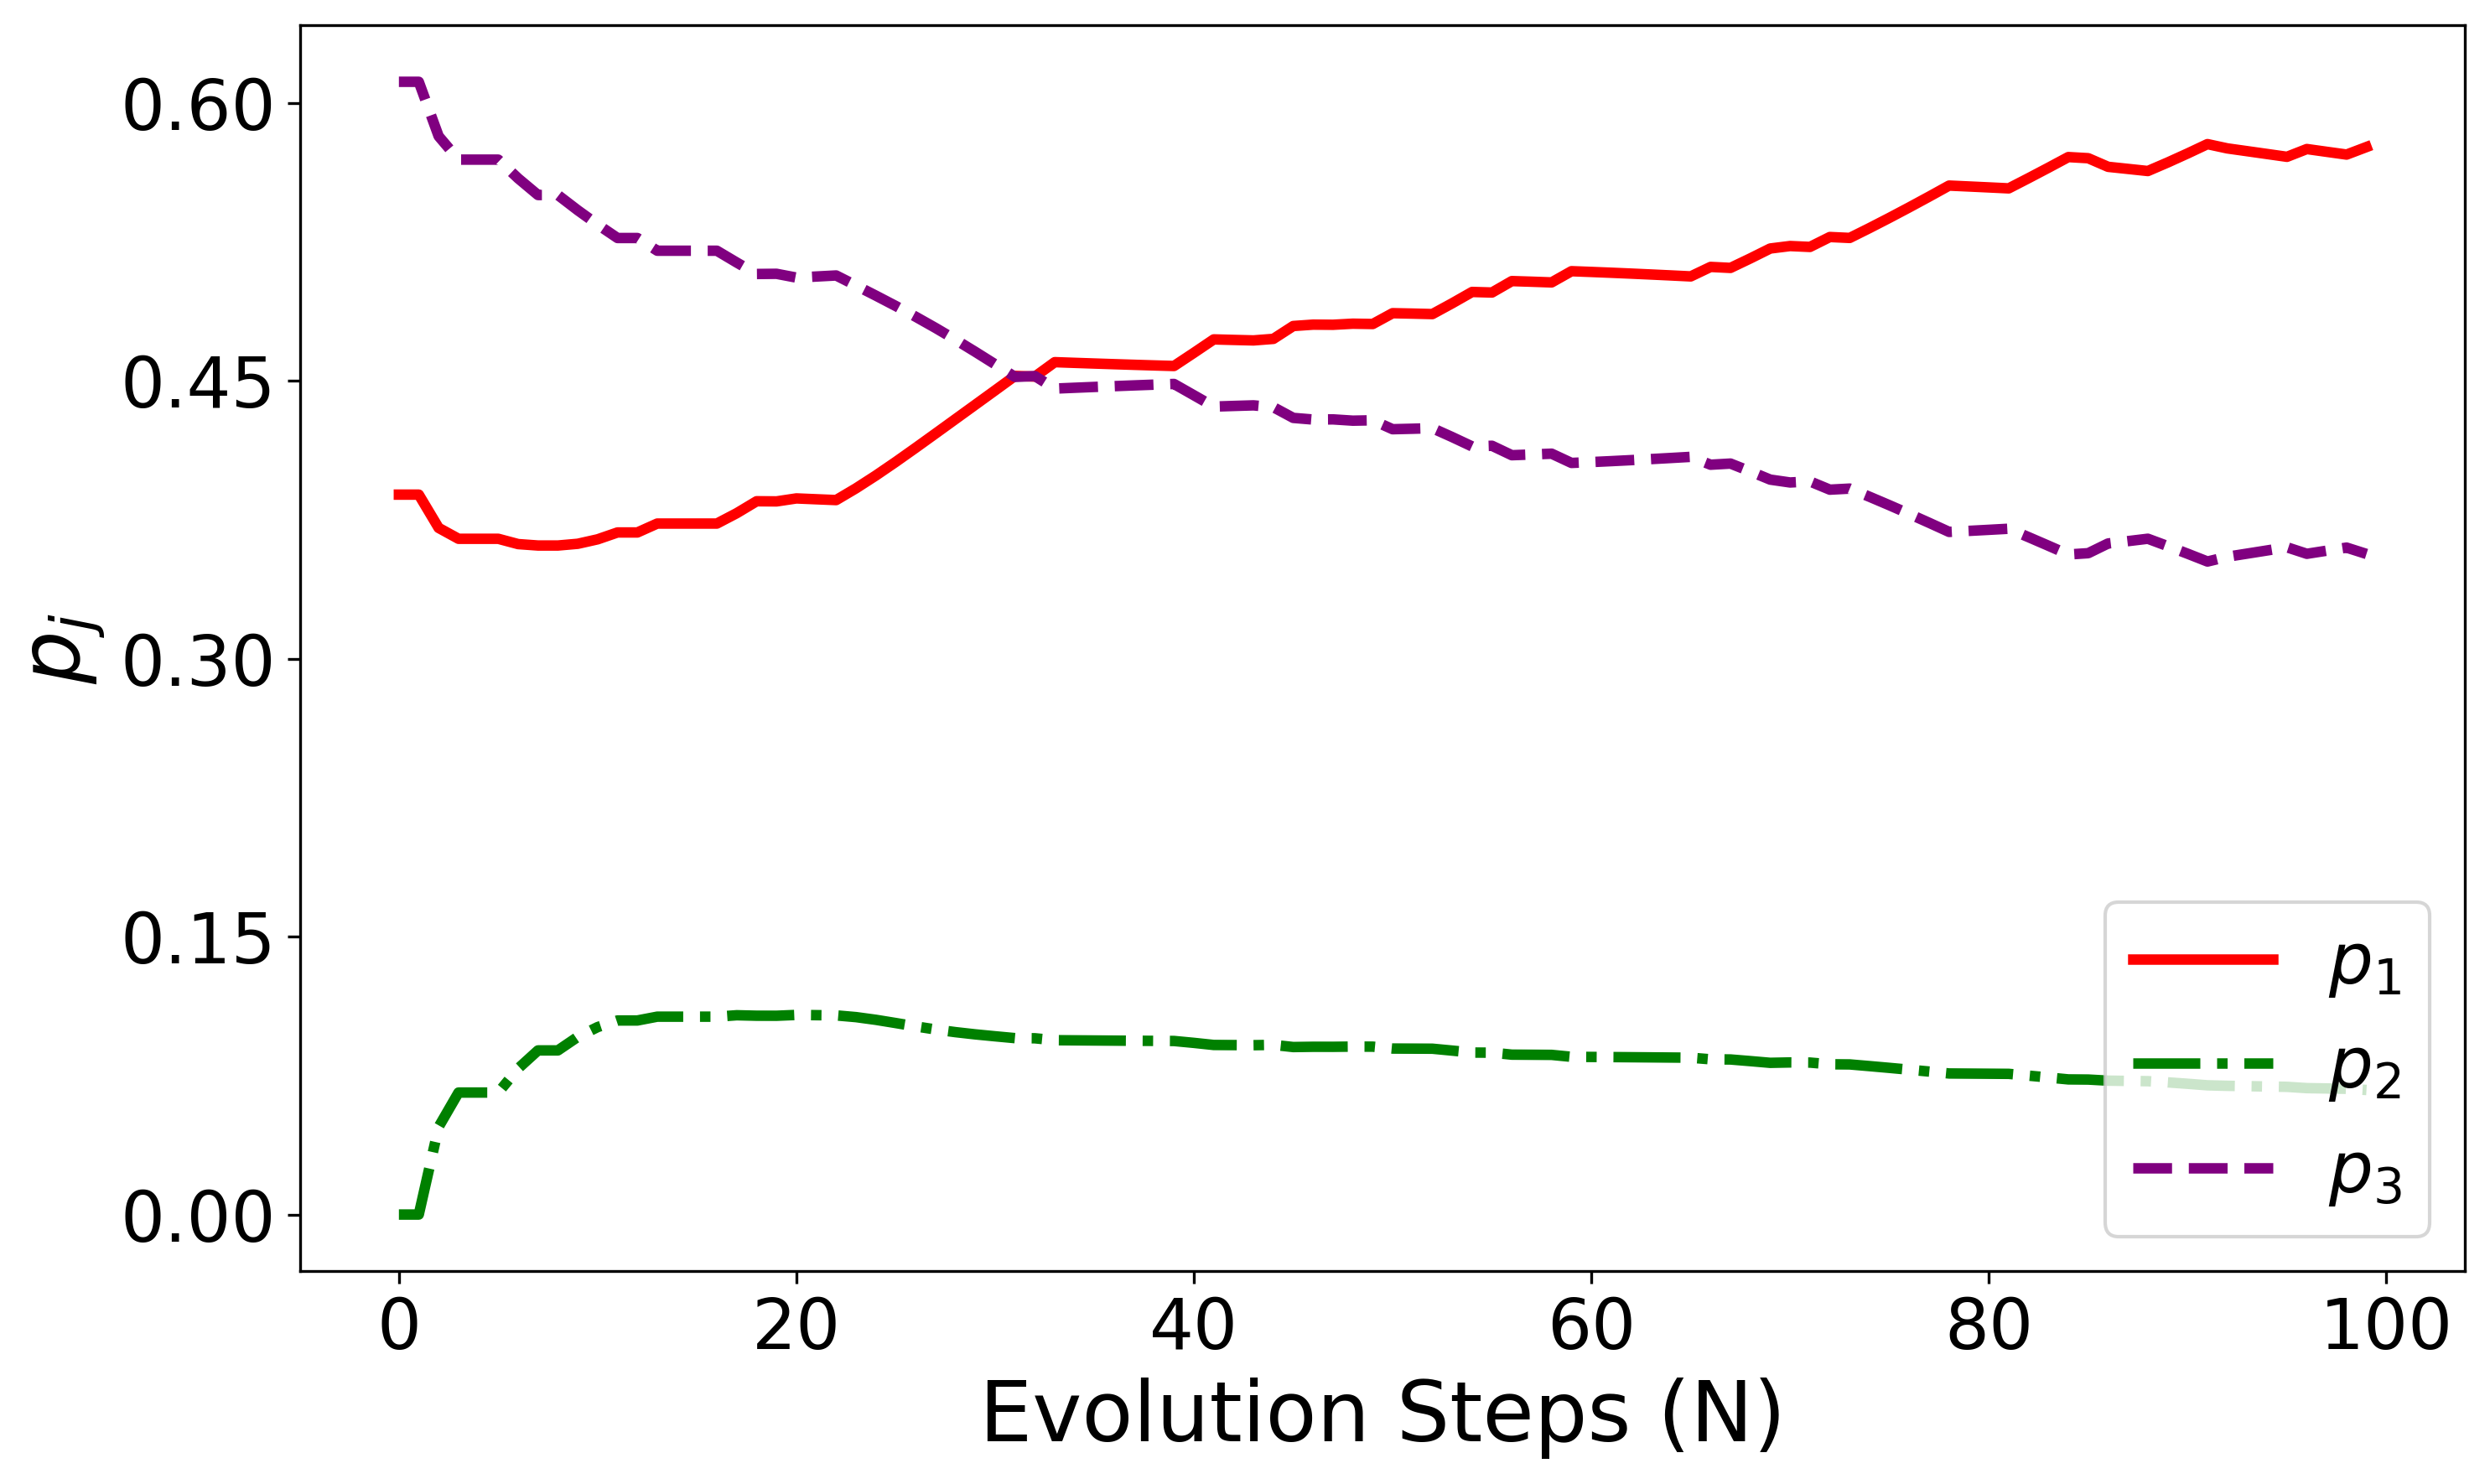

In [16]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(range(steps), p1_list, label=r"${p}_{1}$", color='red', linestyle='-', linewidth=3)
plt.plot(range(steps), p2_list, label=r"${p}_{2}$", color='green', linestyle='-.', linewidth=3)
plt.plot(range(steps), p3_list, label=r"${p}_{3}$", color='purple', linestyle='--', linewidth=3)
plt.xlabel("Evolution Steps (N)", fontsize=24)
plt.ylabel(r"$p_{j}$", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, loc='lower right')

ax = plt.gca()  # 获取当前坐标轴
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()
plt.show()

In [17]:
range(steps)

range(0, 100)

In [18]:
p1_list

[0.3885837571749016,
 0.3885837571749016,
 0.3706197197819696,
 0.36474388216336867,
 0.3647438821633803,
 0.364743882163394,
 0.361882412112821,
 0.36111122960565734,
 0.36111122960566566,
 0.36205016690090536,
 0.36446084862486516,
 0.3681601287560044,
 0.3681601287560868,
 0.3729627331424491,
 0.3729627331418342,
 0.37296273314139405,
 0.3729627331409754,
 0.37857666510238036,
 0.3850058351566772,
 0.384926934536524,
 0.38653160994545416,
 0.3860787654699747,
 0.3856336828451275,
 0.3919853592192543,
 0.3989058159075302,
 0.40623736150406736,
 0.41382728379192996,
 0.4215463936163042,
 0.42930720885253015,
 0.43707259715144714,
 0.4448488208689084,
 0.4526659209654464,
 0.45227679678801336,
 0.46007807525758704,
 0.4597032017147022,
 0.4593380083696685,
 0.4589839034421921,
 0.4586424166781908,
 0.4583152148624111,
 0.45800410918867507,
 0.4651146860440912,
 0.47236534933903623,
 0.4720799795505021,
 0.47181353910905555,
 0.4726459363944833,
 0.47958414753664613,
 0.4803327451463188

In [19]:
p2_list

[1.1180428456922195e-05,
 1.1180428456922195e-05,
 0.047340367697281345,
 0.0658590183862722,
 0.06585901838627178,
 0.0658590183862719,
 0.07884991975968755,
 0.08860246273712906,
 0.0886024627371311,
 0.09589424166019403,
 0.1011887128427032,
 0.10475602060898705,
 0.10475602060901013,
 0.10681223884476024,
 0.10681223884491355,
 0.10681223884504594,
 0.10681223884512883,
 0.10757929567667929,
 0.10732436880690237,
 0.1073023744408872,
 0.10774969435055404,
 0.10762345925731473,
 0.10749938786042497,
 0.10656881221329298,
 0.10511242077585284,
 0.1033687179081141,
 0.1015699942345859,
 0.09990159733039876,
 0.09846499423494837,
 0.09726361468465408,
 0.09622176102328471,
 0.09522755571981147,
 0.0951456954731355,
 0.09411127151904361,
 0.09403458926079866,
 0.0939598871354427,
 0.09388745320136033,
 0.09381760037573046,
 0.09375066960771,
 0.09368703138605453,
 0.09266914129073622,
 0.09153291877836865,
 0.09147762105233452,
 0.09142599137348462,
 0.09158728972706043,
 0.090419838237

In [20]:
p3_list

[0.6114050623966415,
 0.6114050623966415,
 0.582039912520749,
 0.5693970994503591,
 0.5693970994503479,
 0.5693970994503341,
 0.5592676681274914,
 0.5502863076572136,
 0.5502863076572032,
 0.5420555914389006,
 0.5343504385324316,
 0.5270838506350084,
 0.5270838506349032,
 0.5202250280127907,
 0.5202250280132523,
 0.52022502801356,
 0.5202250280138957,
 0.5138440392209404,
 0.5076697960364205,
 0.5077706910225888,
 0.5057186957039919,
 0.5062977752727106,
 0.5068669292944475,
 0.5014458285674527,
 0.4959817633166169,
 0.49039392058781867,
 0.4846027219734842,
 0.4785520090532971,
 0.4722277969125214,
 0.4656637881638988,
 0.4589294181078068,
 0.4521065233147421,
 0.4525775077388512,
 0.4458106532233694,
 0.4462622090244992,
 0.4467021044948888,
 0.4471286433564475,
 0.44753998294607883,
 0.44793411552987894,
 0.44830885942527054,
 0.44221617266517266,
 0.4361017318825951,
 0.43644239939716334,
 0.4367604695174597,
 0.43576677387845625,
 0.4299960142254767,
 0.4291062775161912,
 0.429194